# Réseaux de chaleur urbains - Cas d'étude

***Auteur : Charlotte Gressel, étudiante ingénieur à l'école des Mines, 2025***

## Sous-cas d'étude n°3 : Nouvelle contrainte $ R_{net} \geq d $

Ce notebook étudie le cas d'étude de la ville de Grandvilliers. Dans les notebook précédents, nous appliquons l'agorithme de tracé selon la contrainte $ R_{net} + R \geq d $. Dans ce sous-cas d'étude, nous allons étudier les conséquences du changement de cette contrainte en $ R_{net} \geq d $. Cette nouvelle contrainte, plus restrictive, devrait ne sélectionner que les plus gros bâtiments. 

L'actualisation de $ R_{net}$ et le classement des bâtiments selon la demande en chaleur décroissante restent inchangés.

Nous avons également inséré un algorithme permettant de calculer le `lambda_` optimal permettant de choisir la densité linéique maximale pour le réseau. Si elle est inférieure à 1.5 GWh/km, e réseau n'est pas économique viable.


*Chargement des modules :*

In [6]:
from shapely.geometry import shape, LineString, MultiLineString, Point, Polygon
from shapely.ops import nearest_points
import fiona

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import geopandas as gpd

## Extraction et filtrage des données géographiques et énergétiques

Dans cette partie, deux principaux fichiers sont à l'étude : 
- Un fichier des bâtiments pour un département choisi, téléchargé sur le site BD TOPO® de Géoservices (base BDNB) au format Geopackage
- Un fichier des routes pour un département choisi, téléchargé sur le site BD CARTO® de Géoservices au format Geopackage

Elles ont ensuite été exploités avec le logiciel GQIS afin d'extraire et exporter uniquement les attributs à étudier, à savoir `Bâtiments groupes > Classe DPE (DPE réels)` pour les bâtiments et `BDT_3-~1 — troncon_de_route` pour les routes. 

Il est important de souligner que l'étude est faite à partir de données **départementales** et non nationales, notamment pour des raisons de format des données téléchargeables et du temps de calcul. Le département choisi dans l'étude qui suit est l'Oise.

In [9]:
# Chemins vers les fichiers GeoPackage
buildings_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/test60/bat_oise.gpkg"
roads_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/test60/routes_oise.gpkg"

### Sélection de la zone d'étude

On commence par sélectionner le lieu que l'on souhaite étudier à partir de l'attribut `code_commune_insee`.

**Attention!** Le `code_commune_insee` n'est pas le même que le code postal connu de tous. Il est donc nécessaire de rechercher sur le site de l'Insee le code commune de la zone à étudier.

Ici, nous étudierons la communes de **Grandvilliers (60286)**.

In [12]:
# Demande du code postal de la ville/lieu à étudier

def ask_code_commune():
    while True:
        code_postal = input("Veuillez entrer le code postal de la commune que vous souhaitez étudier : ")
        
        # Validation simple : vérifier que le code postal contient exactement 5 chiffres
        if code_postal.isdigit() and len(code_postal) == 5:
            return code_postal
        else:
            print("Le code commune Insee doit contenir exactement 5 chiffres. Veuillez réessayer.")

def find_libelle_commune(code_commune):
    buildings_fiona = fiona.open(buildings_file)

    libelle_commune = None
    for building in buildings_fiona:
        building_properties = building["properties"]
        if building_properties["code_commune_insee"] == code_commune:
            libelle_commune = building_properties["libelle_commune_insee"]
            break  # On arrête dès qu'on trouve un match
    
    buildings_fiona.close()

    return libelle_commune

code_comm_insee = ask_code_commune()
libelle_commune = find_libelle_commune(code_comm_insee)

print(f"Code commune Insee retenu : {code_comm_insee}")
print(f"Commune sélectionnée : {libelle_commune}")

Veuillez entrer le code postal de la commune que vous souhaitez étudier :  60286


Code commune Insee retenu : 60286
Commune sélectionnée : Grandvilliers


### Sélection des bâtiments et des routes

#### 1<sup>er</sup> filtrage: sélection des bâtiments et des routes de la commune choisie

On commence par sélectionner les bâtiments de la commune choisie. Les bâtiments devront également répondre à un critère de hauteurs supérieur à 3 mètres. 

Cette opération est la plus chronophage en raison du nombre important de bâtiments à parcourir (390 581 ici).

In [16]:
# Extraction des bâtiments
buildings_fiona = fiona.open(buildings_file)

buildings = []  # bâtiments qui seront considérés pour le RCU

for building in tqdm(buildings_fiona, desc="Extraction des bâtiments", unit="bâtiment"):
    properties = building["properties"]
    
    # Vérification des conditions sur les propriétés
    if (properties["code_commune_insee"] == code_comm_insee and
        properties["s_geom_groupe"] is not None and
        properties["ffo_bat_annee_construction"] is not None and
        properties["bdtopo_bat_hauteur_mean"] is not None and
        properties["bdtopo_bat_hauteur_mean"] >= 3 and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] is not None and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] != "N"):
        buildings.append(building)

buildings_fiona.close()

print(len(buildings), "bâtiments ont été retenus.")

Extraction des bâtiments: 100%|█████████████████████████████████████████| 390581/390581 [06:41<00:00, 973.71bâtiment/s]


153 bâtiments ont été retenus.


On sélectionne ensuite les routes de la commune choisie grâce à la commune qui se trouve à droite et à gauche de la route. On ne conserve que les routes "intérieures", à savoir celles dont la commune à droite et à gauche est celle qui porte le code commune Insee sélectionné.

In [18]:
# Extraction des routes
roads_fiona = fiona.open(roads_file)

roads = []

print("Analyse des routes en cours...")
for road in tqdm(roads_fiona, desc="Progression", unit="route"):
    properties = road["properties"]

    # Condition pour filtrer les routes
    if (properties["insee_commune_gauche"] == code_comm_insee) and \
       (properties["insee_commune_droite"] == code_comm_insee):
        
        roads.append(road)

# Fermeture du fichier et affichage des résultats
nb_roads = len(roads)
roads_fiona.close()

print(f"{nb_roads} routes ont été retenues.")

Analyse des routes en cours...


Progression: 100%|████████████████████████████████████████████████████████| 239444/239444 [01:47<00:00, 2228.25route/s]

350 routes ont été retenues.


Visualisons ce premier filtrage sur un graphe.

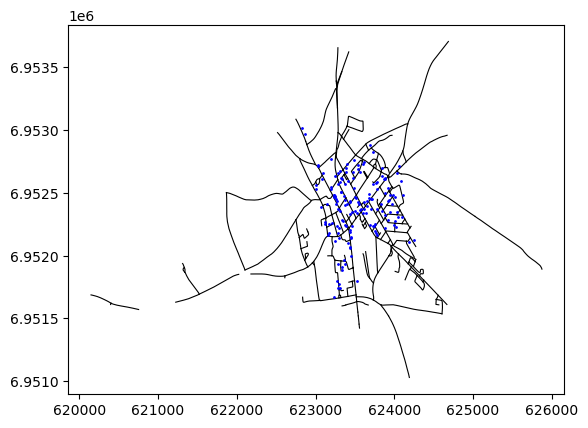

In [20]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=1)

#### 2<sup>ème</sup> filtrage : Sélection des routes proches des bâtiments (optionnel)

Cette étape permet une meilleure visualisation du réseau afin de mieux positionner l'usine à chaleur.

In [22]:
building_polygons = [shape(building["geometry"]) for building in buildings]

filtered_roads = []
distance_max = 500  # Distance maximale de 500 mètres (à modifier si besoin)

# Parcourir uniquement les routes déjà pré-sélectionnées
for road in roads:
    road_geom = shape(road["geometry"])

    # Vérification si la route est proche d'un bâtiment
    if any(road_geom.distance(building_geom) <= distance_max for building_geom in building_polygons):
        filtered_roads.append(road)

# Affichage du nombre de routes retenues après filtrage
roads = filtered_roads
nb_roads = len(roads)
print(f"{nb_roads} routes sont proches des bâtiments (moins de {distance_max}m).")

324 routes sont proches des bâtiments (moins de 500m).


### Affichage du quartier d'étude final :

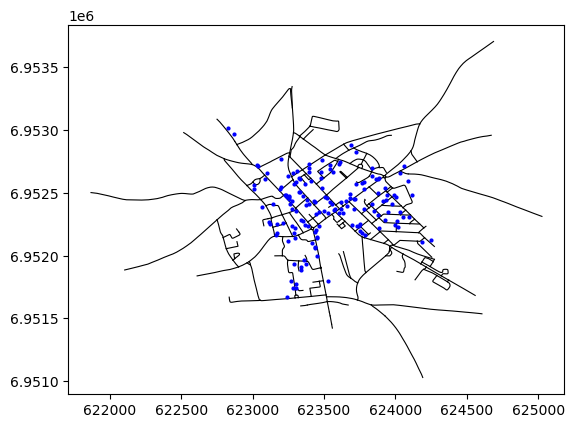

In [24]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

# Représentation des bâtiments par des points avec numérotation
for building in buildings:  # Démarre la numérotation à 1
    polygon_batiment = shape(building["geometry"])
    centroid = polygon_batiment.centroid  # Coordonnées du centre du bâtiment

    # Tracé du point central du bâtiment
    plt.plot(centroid.x, centroid.y, 'bo', markersize=2)

#### Définition de l'Usine à chaleur

Nous recherchons à présent une zone où positionner l'usine à chaleur. Dans ce cas d'étude, nous ferons l'hypothèse que l'usine à chaleur à proximité des bâtiments du quartier d'étude, mais également d'un champs dans lequel on istallera hypothétiquement des panneaux solaires. 

Une photo aérienne de la ville de Chaumont-en-Vexin nous permet d'identifier une zone potentielle répondant à ces critères :

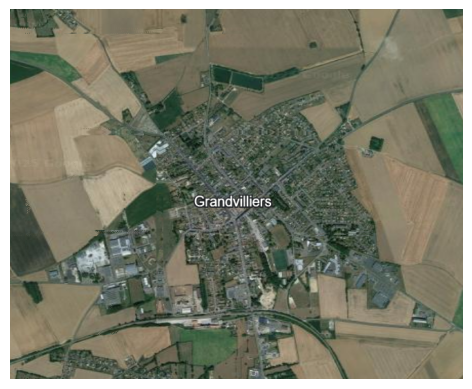

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Utilisation d'un raw string (r"...")
chemin_image = r"C:\Users\charl\OneDrive\Documents\Documents\4. Mines\2. EFFINERSYS\Réseaux de chaleur et transition énergétique\Image_Grandvilliers.png"

# Charger et afficher l'image
img = mpimg.imread(chemin_image)
plt.imshow(img)
plt.axis('off')  # Masquer les axes
plt.show()

Nous décidons alors de positionner arbitrairement notre usine à chaleur à proximité du champs en haut au centre. On sélectionne les coordonnées manuellement, en se mettant à l'échelle du graphe précédent.

In [28]:
from fiona.model import Feature
from shapely.geometry import Point, mapping

# 🔵 SÉLECTION DE L'USINE À CHALEUR 🔵

def choisir_usine():
    print("Veuillez choisir une usine parmi les trois disponibles :")
    print("1 - Usine 1 (Longitude: 623000, Latitude: 6.95242 * 1e6)")
    print("2 - Usine 2 (Longitude: 624100, Latitude: 6.9527 * 1e6)")
    print("3 - Usine 3 (Longitude: 623500, Latitude: 6.95285 * 1e6)")
    
    choix = input("Entrez le numéro de l'usine (1, 2 ou 3) : ")
    
    usines = {
        "1": (623000, 6.95242 * 1e6),
        "2": (624100, 6.9527 * 1e6),
        "3": (623500, 6.95285 * 1e6)
    }
    
    return usines.get(choix, usines["1"])  # Par défaut, Usine 1

# Récupération des coordonnées en fonction du choix de l'utilisateur
longitude, latitude = choisir_usine()
new_point = Point(longitude, latitude)  # Création du point Shapely

# Définition des propriétés du nouveau bâtiment
heat_plant_properties = {
    "code_commune_insee": "XXXXX",  # Remplacez par la valeur appropriée
    "s_geom_groupe": 300,  # Surface arbitraire en m²
    "ffo_bat_annee_construction": 2000,  # Année fictive
    "bdtopo_bat_hauteur_mean": 20,  # Hauteur arbitraire en mètres
    "dpe_mix_arrete_classe_conso_energie_arrete_2012": "C"  # Classe énergétique fictive
}

# Créer l'objet Feature pour l'usine à chaleur
heat_plant = Feature(
    id=None,  # ID automatique ou défini manuellement
    geometry=mapping(new_point),  # Conversion de la géométrie Shapely vers GeoJSON
    properties=heat_plant_properties  # Propriétés associées
)

Veuillez choisir une usine parmi les trois disponibles :
1 - Usine 1 (Longitude: 623000, Latitude: 6.95242 * 1e6)
2 - Usine 2 (Longitude: 624100, Latitude: 6.9527 * 1e6)
3 - Usine 3 (Longitude: 623500, Latitude: 6.95285 * 1e6)


Entrez le numéro de l'usine (1, 2 ou 3) :  1


<u>Affichage de l'usine à chaleur : </u>

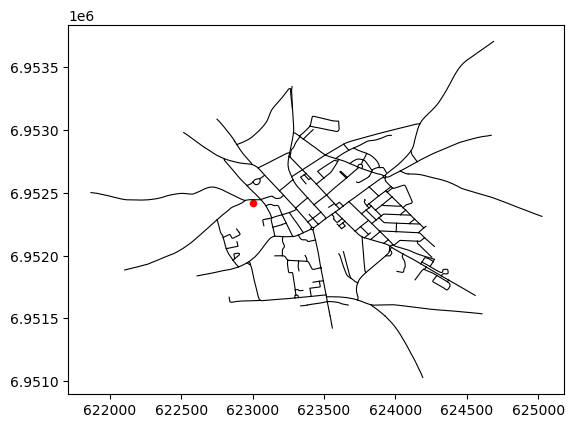

In [30]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

heat_point = shape(heat_plant["geometry"])
plt.scatter(heat_point.x, heat_point.y, color="red", s=20, label="Usine à chaleur")

#### 3<sup>ème</sup> filtrage : Sélection des bâtiments connectables


##### Calcul de la consommation des bâtiments et sélection du plus grand consommateur

Nous nous basons sur l'attribut `dpe_class_to_consumption` pour évaluer la consommation des bâtiments. La lettre attribuée à chaque bâtiment est associée à sa consommation énergétique moyenne en kWh/m²/an.

Nous estimons alors la consommation énergétique annuelle moyenne de chaque bâtiment à partir de leurs DPE moyen, surface et hauteur, par la formule suivante :

$$
Q \approx DPE \times S \times E\left(\frac{h}{h_0}\right)
$$

Où $h_0 = 3m$ et où $E$ est la fonction partie entière, afin d'introduire une estimation du nombre d'étages pour chaque bâtiment.

In [34]:
# Calcul des demandes en chaleur pour tous les bâtiments retenus

# Fonction de mapping de la classe DPE à la consommation énergétique (kWh/m²/an)
def dpe_class_to_consumption(dpe_class):
    dpe_map = {
        "A": 50,  # Consommation max pour A est 50
        "B": 90,  # Consommation max pour B est 90
        "C": 150, # Consommation max pour C est 150
        "D": 230, # Consommation max pour D est 230
        "E": 330, # Consommation max pour E est 330
        "F": 450, # Consommation max pour F est 450
        "G": 500  # On considère 500 comme une valeur représentative pour G (au-delà de 450)
    }
    return dpe_map[dpe_class]  # Pas besoin de valeur par défaut ici

# Calcul des demandes en chaleur pour tous les bâtiments retenus
h_0 = 3  # mètres, taille d'un étage
nb_buildings = len(buildings)
heat_demands = np.zeros(nb_buildings)

for k, building in enumerate(buildings):
    properties = building["properties"]
    
    # Conversion de la classe DPE en consommation d'énergie
    dpe_class = properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"]  # Aucun défaut nécessaire
    dpe_consumption = dpe_class_to_consumption(dpe_class)
    
    # Calcul de la demande en chaleur en kWh/an
    Q = dpe_consumption * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
    heat_demands[k] = Q

In [35]:
# CLASSEMENT suivant les CONSOMMATIONS DECROISSANTES
sorted_index = np.argsort(heat_demands)[::-1]
heat_demands = np.sort(heat_demands)[::-1]
buildings = [buildings[index] for index in sorted_index]

##### Détermination des bâtiments connectables

Le critère de connexion est défini sur le site **France Chaleur** : au-delà de $30kW$, un bâtiment doit dans la plupart des cas être considéré pour le tracé du réseau de chaleur.

La puissance thermique maximale demandée par les habitations est estimée grâce à une technique définie dans la section suivante. On réalisera alors le filtrage des bâtiments selon ce critère.

Ce procédé permet de trouver le compromis entre une demande raccordée maximale en premier plan et un nombre de bâtiments raccordé minimal afin de limiter les coûts.

##### Estimation de la consommation énergétique annuelle moyenne

Afin de réaliser la simulation d'un réseau de chaleur avec le logiciel Dymola, il faut estimer leurs demandes instantanées tout au long de l'année. Pour cela, nous utilisons la méthode décrite dans les sections suivantes.

Nous utilisons des profils typiques de demande en chaleur. Nous disposons de trois fichiers correspondant aux courbes typiques des bâtiments construits durant les périodes suivantes :
* Avant 1989 (exclu) : `RT_1974_Treated.csv` (il s'agit en réalité des normes des bâtiments construits entre 1974 et 1989);
* Entre 1989 (inclus) et 2005 (exclu) : `RT_1989_Trated.csv` (il s'agit des normes des bâtiments construits entre 1989 et 2005);
* Après 2005 (inclus) : `RT_2005_Treated.csv`.

Il s'agit de timeseries que nous allons manipuler avec `pandas`.

In [41]:
heat_profile_1974 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_1974_Treated.csv", index_col=0)
heat_profile_1989 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_1989_Treated.csv", index_col=0)
heat_profile_2005 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_2005_Treated.csv", index_col=0)

On calcule ensuite la puissance thermique demandée pour chaque bâtiment à partir de la formule suivante:
$$
\Phi_{th} = D_m \cdot c_p \cdot (T_{départ} - T_{retour})
$$

Puis on calcule le coefficient de demande en chaleur associé à chaque bâtiment:
$$
\alpha_k = \frac{Q_{total}}{\left( \sum_{1 \, \text{an}} \Phi_{th,ref} \right) \cdot \Delta t}
$$


In [43]:
# Tableau des coefficients alpha
heat_profile_coeff_tab = np.zeros(nb_buildings)

# Constantes
cp_water = 4180 # J/K/kg
delta_t = 1 # h (l'énergie est en kWh)

# Initialisation
sum_power = np.zeros(3)

# Fonction pour catégoriser les bâtiments suivant leur année de construction
def categorize(building):
    construction_date = building["properties"]["ffo_bat_annee_construction"]
    # 0 : avant 1989 exclu
    if construction_date < 1989:
        return 0
    # 1 : entre 1989 inclus et 2005 exclu
    elif 1989 <= construction_date < 2005:
        return 1
    # 2 : après 2005 exclu
    else:
        return 2
    
df_tab = [heat_profile_1974, heat_profile_1989, heat_profile_2005]

# Calcul de la colonne des puissances dans les dataframes de référence
def add_power_column(df):
    df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)
    
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    # Ajout de la colonne puissance
    add_power_column(df)
    # Calcul de la somme des puissances
    sum_power[k] = df.Puissance.sum()

# Calcul des coefficients pour chaque bâtiment hors usine à chaleur
for k, building in enumerate(buildings):
    category = categorize(building)
    heat_profile_coeff_tab[k] = heat_demands[k] / (delta_t * sum_power[category] * 1e-3) # attention unités : kWh / kWh

C:\Users\charl\AppData\Local\Temp\ipykernel_31936\3192598625.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)


On ne conserve que les bâtiments dont la puissance maximale demandée excède $30kW$.

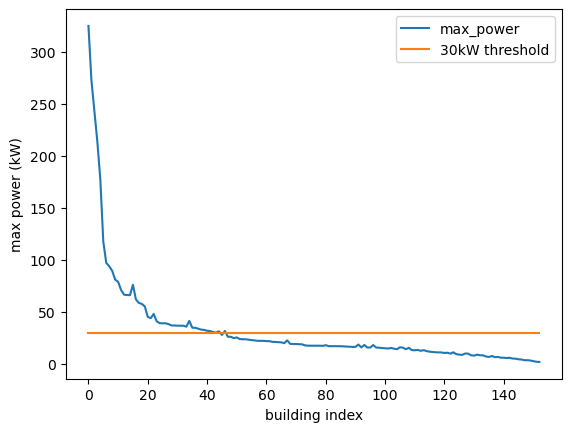

In [45]:
# Tableau du max des puissances pour chaque bâtiment
max_power = np.zeros(nb_buildings)
for k, building in enumerate(buildings):
    max_power[k] = heat_profile_coeff_tab[k] * np.max(df_tab[categorize(building)].Puissance)
plt.plot(max_power*1e-3, label="max_power")
plt.plot([30 for _ in range(nb_buildings)], label="30kW threshold")
plt.xlabel("building index")
plt.ylabel("max power (kW)")
plt.legend();

In [46]:
mask = np.array([power > 30e3 for power in max_power])
buildings = [buildings[k] for k in range(nb_buildings) if mask[k]]
nb_buildings = len(buildings)
print("Nombre de bâtiments sélectionnés après le deuxième filtrage :", nb_buildings)

Nombre de bâtiments sélectionnés après le deuxième filtrage : 46


Avant de passer au pré-découpage et à l'algorithme, reste à ajuster le format de `heat_building`.

**NE PAS REEXECUTER CES DEUX CELLULES**

In [49]:
heat_point = heat_plant["geometry"]["coordinates"]
heat_plant["geometry"]["coordinates"] = []
heat_plant["geometry"]["coordinates"].append([])
heat_plant["geometry"]["coordinates"][0].append([])
heat_plant["geometry"]["coordinates"][0][0].append(heat_point)

On ajoute l'usine à chaleur **à la fin** de la liste `buildings`.

In [51]:
if len(buildings) == 47:
    del buildings[46]

In [52]:
buildings.append(heat_plant)
nb_buildings = len(buildings)
print(f"Nombre de bâtiments final : {nb_buildings}")

Nombre de bâtiments final : 47


## Visualisation du quartier d'intérêt

Nous pouvons enfin visualiser le quartier d'intérêt après tous les filtrages nécessaires :

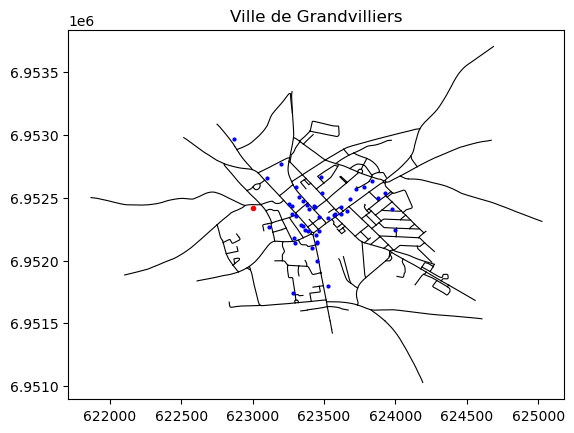

In [54]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=2)

# Représentation de l'usine à chaleur
polygon_plant = shape(heat_plant["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=3);

plt.title(f"Ville de {libelle_commune}")
plt.show()

Légende :
* Ligne noire: route
* Point bleu: bâtiment
* Point rouge: usine à chaleur

### Préparation des routes pour l'algorithme Dijkstra

L'algorithme d'origine parcourt les routes dans leur intégralité, en suivant la longueur et l'ordre des tronçons. Chaque tronçon de route est modélisé par un objet `LineString` de la bibliothèque `Shapely`, lui-même composée d'une suite de points entre lesquels une droite est tracée. Or, dans les données brutes téléchargées, ces tronçons sont ordonnées et découpées de façon aléatoires. Par exemple, une route faisant 1km et ne diposant que d'un seul bâtiment au début de cette route, dison à 10m, sera ajoutée au réseau dans son intégralité si ce bâtiment est sélectionné dans le réseau. 

D'autre part, dans le logiciel de simulation Dymola, chaque tronçon est modélisé par un tuyau, et chaque tuyau est traversé par un débit qui dépend des ba^timents en amont et en aval. En conséquence le modèle devient vite compliqué vue le nombre des tronçons à modéliser dans le modèle actuel. Pour que la simulation soit effective, il est nécessaire qu'un tronçon de route soit unique entre deux bâtiments à connecter au réseau.


Il s'agit donc dans le code ci-dessous de réunir et redécouper ces routes de sorte à ce que leurs extrémités ne soient plus posées de façon aléatoires mais existent si et seulment si elles rencontrent un bâtiment ou une intersection.

**1<sup>ère</sup> étape : Projection des bâtiments sur les routes**

On commence par projeter la localisation des bâtiments sur les routes.

In [58]:
projected_buildings = []

for building in buildings:
    polygon_building = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid = polygon_building.centroid
    building_point = Point(centroid.x, centroid.y)

    # Trouver la route la plus proche du bâtiment
    closest_route = None
    min_distance = float("inf")
    for route in roads:
        line = LineString(route["geometry"]["coordinates"])
        distance = line.distance(building_point)
        if distance < min_distance:
            min_distance = distance
            closest_route = line

    # Projeter le point du bâtiment sur la route la plus proche
    projected_building = closest_route.interpolate(closest_route.project(building_point))
    projected_building = Point(projected_building.x, projected_building.y)
    projected_buildings.append(projected_building)

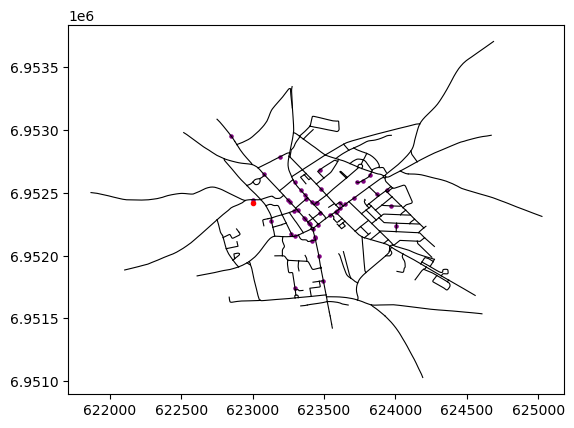

In [59]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Représentation des bâtiments par des points
for building in projected_buildings:
    plt.scatter(building.x, building.y, color="purple", s=5, label="Bâtiments projetés sur routes")

# Représentation de l'usine à chaleur
polygon_plant = shape(heat_plant["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=3);

**2<sup>ème</sup> étape : Réunion et découpage des routes**

Pour le moment, les routes sont découpées de façon aléatoires. Pour visualiser ceci, nous allons affecter de façon aléatoire une parmi quatre couleurs à chaque tronçon.

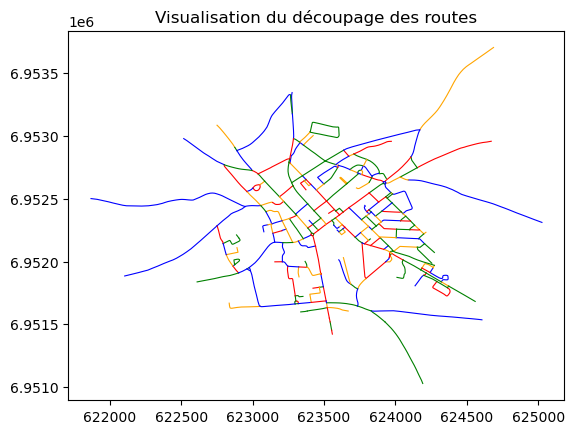

In [61]:
import random

# Liste de couleurs parmi lesquelles choisir
colors = ["blue", "green", "red", "orange"]

# Tracer les routes avec des couleurs aléatoires
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    # Choisir une couleur aléatoire pour la route
    color = random.choice(colors)

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route avec la couleur choisie
        plt.plot(x_ligne1, y_ligne1, color=color, linewidth=0.8)

# Ajouter un titre pour clarifier
plt.title("Visualisation du découpage des routes")
plt.show()


*1) Réunion des routes jusque chaque croisement*

In [63]:
from shapely.ops import linemerge

roads_to_linestring =[]

for route in roads:
    line = LineString(route["geometry"]["coordinates"])
    roads_to_linestring.append(line)

# On réunit toutes les routes ensemble en un seul objet MultiLineString
multi_line = MultiLineString(roads_to_linestring)

# La commande linemerge permet de réunir les routes qui se joignent
merged_roads = linemerge(multi_line)

print(f"Nombre de routes après réunion: {len(merged_roads.geoms)}")

Nombre de routes après réunion: 307


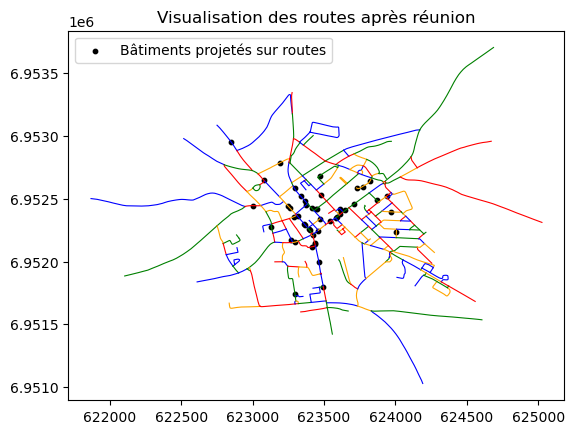

In [64]:
colors = ["blue", "green", "red", "orange"]

# Tracer les routes avec des couleurs aléatoires
for line in merged_roads.geoms:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur aléatoire pour chaque ligne
    x, y = line.xy  # Extraire les coordonnées X et Y de la ligne
    plt.plot(x, y, color=color, linewidth=0.8)

# Représentation des bâtiments par des points
for building in projected_buildings:
    plt.scatter(building.x, building.y, color="black", s=10, label="Bâtiments projetés sur routes")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("Visualisation des routes après réunion")
plt.show()

*2) Découpage des routes au niveau des projections des bâtiments*

In [94]:
def split_routes(merged_connected_roads, projected_buildings2, safety_distance=10):
    split_connected_roads = []

    if isinstance(merged_connected_roads, LineString):
        routes = [merged_connected_roads]
    else:
        routes = list(merged_connected_roads.geoms)

    for route in routes:
        if len(route.coords[0]) == 3:  # Cas où la coordonnée contient (x, y, z)
            route = LineString([(x, y) for x, y, z in route.coords])  # Ignorer le z
        elif len(route.coords[0]) == 2:  # Cas où la coordonnée contient (x, y)
            route = LineString([(x, y) for x, y in route.coords])  # Garde seulement (x, y)
        else:
            # Si les coordonnées n'ont ni 2 ni 3 éléments, on peut ignorer la route
            print(f"Route avec coordonnées inattendues: {route.coords}")
            continue

        # Vérifier si des points sont proches de la route, mais à une distance suffisante des extrémités
        no_points_nearby = True
        for point in projected_buildings2:
            distance_to_route = point.distance(route)
            distance_to_start = point.distance(Point(list(route.coords)[0]))
            distance_to_end = point.distance(Point(list(route.coords)[-1]))

            # Si le point est proche de la route mais loin des extrémités, nous allons découper la route
            if distance_to_route < 10 and (distance_to_start > safety_distance and distance_to_end > safety_distance):
                no_points_nearby = False
                break  # Sortir de la boucle dès qu'un point valide est trouvé

        # Si aucun point n'est proche de la route, ajouter la route sans modification
        if no_points_nearby:
            split_connected_roads.append(route)
            continue

        # Récupérer les points proches de la route
        points_in_route = [point for point in projected_buildings2 if point.distance(route) < 10]
        points_in_route.insert(0, Point(list(route.coords)[0]))  # Ajouter le début de la route
        points_in_route.append(Point(list(route.coords)[-1]))  # Ajouter la fin de la route

        if len(points_in_route) > 2:
            # Trier les points par distance croissante par rapport au début de la route
            points_in_route = sorted(points_in_route, key=lambda p: route.project(p))

            # Diviser la route en segments successifs
            previous_position = 0
            last_segment_coords = []  # Liste pour stocker le dernier segment

            for i, point in enumerate(points_in_route):
                current_position = route.project(point)

                # Extraire les coordonnées du segment de la position précédente à la position actuelle
                segment_coords = [
                    coord for coord in route.coords
                    if route.project(Point(coord)) >= previous_position
                    and route.project(Point(coord)) <= current_position
                ]

                # Si ce n'est pas le premier segment, ajoutez le dernier point du segment précédent
                if i != 0:
                    segment_coords.insert(0, last_segment_coords[-1])  # Ajouter le dernier point du segment précédent

                # Ajouter le point de division pour éviter les trous
                segment_coords.append((point.x, point.y))

                # Vérifier que le segment contient plus de 1 point avant de créer le LineString
                if len(segment_coords) > 1:
                    segment = LineString(segment_coords)
                    split_connected_roads.append(segment)

                # Mettre à jour la position précédente et mémoriser le dernier segment
                previous_position = current_position
                last_segment_coords = segment_coords

            # Ajouter le dernier segment entre le dernier point et la fin de la route
            final_segment_coords = [
                coord for coord in route.coords
                if route.project(Point(coord)) >= previous_position
            ]

            # Ajouter la dernière coordonnée pour s'assurer que le dernier point est inclus
            if route.coords[-1] not in final_segment_coords:
                final_segment_coords.append(route.coords[-1])

            # Vérification si final_segment_coords contient plus de 1 point avant de créer le segment
            if len(final_segment_coords) > 1:
                final_segment = LineString(final_segment_coords)
                split_connected_roads.append(final_segment)

        for road in split_connected_roads:
            if road.length == 0 : #On retire les routes de longueur quasi nulle
                split_connected_roads.remove(road)
        
    return split_connected_roads

split_roads = split_routes(merged_roads, projected_buildings, safety_distance=10)

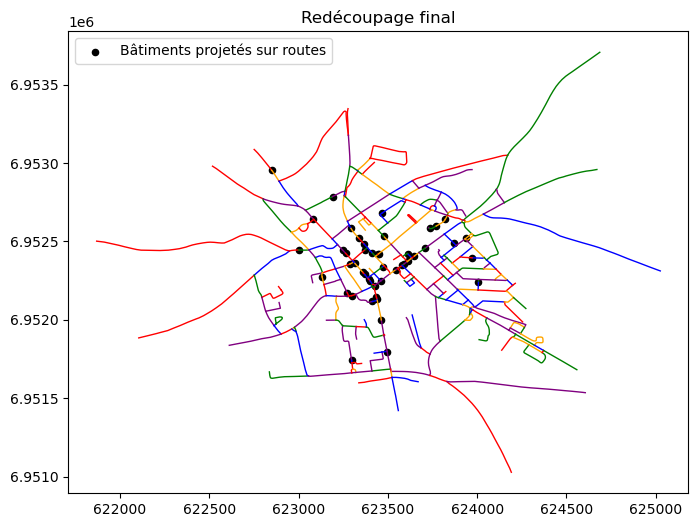

In [95]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ["blue", "green", "red", "orange", "purple"]

# Tracer les routes avec des couleurs aléatoires
for route in split_roads:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur aléatoire pour chaque ligne
    x, y = zip(*route.coords)  # Séparation des coordonnées x et y
    ax.plot(x, y, color=color, linewidth=1)  # Tracé en vert pour les routes connectées

# Représentation des bâtiments par des points
for building in projected_buildings:
    ax.scatter(building.x, building.y, color="black", s=20, label="Bâtiments projetés sur routes")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("Redécoupage final")
plt.show()

*3) Conversion des routes en objet GeoJSON*

In [97]:
from shapely.geometry import mapping

final_roads = []

for line in split_roads:
    geojson_geometry = mapping(line)
    
    # Étape 3 : Créer l'objet Feature sans propriétés
    feature = fiona.model.Feature(
        geometry=geojson_geometry,
        properties={}  # Dictionnaire vide pour les propriétés
    )
    final_roads.append(feature)

In [98]:
nb_roads = len(final_roads)
print(f"Nombre de routes après découpage : {nb_roads}")

Nombre de routes après découpage : 351


## Modélisation du quartier par un graphe

### Définition des noeuds

On définit deux types de noeuds qui possédent de nombreuses propriétés de trois types : topologiques, énergétiques et relatives au réseau de chaleur. On compte comme type de noeud :
* Les bâtiments
* Les routes
* Le plus grand consommateur

Une telle représentation permet de grandement simplifier l'écriture du code.

In [102]:
len(buildings)

47

In [103]:
class Node_building:
    # Un bâtiment sera représenté par un indice et l'objet bâtiment qui y est associé
    def __init__(self, index, lambda_):
        self.index = index
        self.building = buildings[index]
        self.coordinates = self.building["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        properties = self.building["properties"]
        self.heat_demand = heat_demands[index]
        self.radius = self.heat_demand / lambda_
        self.construction_date = properties["ffo_bat_annee_construction"]
        self.heat_profile_coeff = heat_profile_coeff_tab[index]

class Node_road:
    def __init__(self, index):
        self.index = index
        self.road = final_roads[index]

        # Récupérer les coordonnées brutes
        raw_coordinates = self.road["geometry"]["coordinates"]

        # Vérifier si c'est une structure 2D ou 3D, ou un type inattendu
        if isinstance(raw_coordinates[0], (list, tuple)):
            self.coordinates = [
                (coord[0], coord[1]) if len(coord) >= 2 else (coord[0], 0)
                for coord in raw_coordinates
                if isinstance(coord, (list, tuple))  # Vérifie que coord est une liste ou un tuple
            ]
        else:
            # Si la structure est une seule ligne
            self.coordinates = [
                (raw_coordinates[0], raw_coordinates[1]) if len(raw_coordinates) >= 2 else (raw_coordinates[0], 0)
            ]

        # Vérifier si des coordonnées valides ont été trouvées
        if not self.coordinates:
            raise ValueError(f"Aucune coordonnée valide trouvée pour la route à l'index {index}. "
                             f"Données initiales : {self.road['geometry']['coordinates']}")

        # Calcul du centre
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"

        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine à chaleur sera représenté par un indice et l'objet bâtiment qui y est associée
    # Différence avec les noeuds bâtiments : ni demande en chaleur ni rayon caractéristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, heat_plant=heat_plant):
        self.index = nb_buildings
        self.building = heat_plant
        self.coordinates = heat_plant["geometry"]["coordinates"][0][0]
        x, y = zip(*(self.coordinates))
        self.center = (np.mean(x), np.mean(y))
        self.type = "production de chaleur"
        self.predecessor = None

### Modélisation des arêtes

La présence d'une arête entre deux noeuds signifie qu'un tuyau peut joindre directement ces derniers en suivant la route et sans croiser de noeud intermédiaire. Il y a ainsi deux types de noeuds :
* Entre deux tronçons de routes successifs;
* Entre un bâtiment et une route qui lui est proche.

Nous avons fait le choix de ne raccorder que depuis la route les bâtiments, on exclut donc la possibilité de réaliser des tuyaux entre les habitations. Il y aura donc éventuellement une légère surestimation du coût du réseau de chaleur qu'il faudra prendre en compte lors de la présentation du projet.

Les arêtes seront modélisées par des tables d'adjacence représentées par des dictionnaires Python. Il s'agit certes de structures redondantes, mais nous les avons choisi pour leur grande efficacité en terme de temps de calcul. L'encombrement mémoire ne représentera par ailleurs pas un problème étant donnée la faible taille du graphe étudié (de l'odre du millier de noeuds).

### Construction du graphe

Les règles sont les suivantes pour calculer les arêtes :
1. Deux routes sont connectées si et seulement si la distance minimale entre ces dernières est inférieure à 5m;
2. Un bâtiment est connecté à sa route la plus proche.

**1. Définition de l'algorithme de tracé**

In [110]:
class Graph2:

    def __init__(self, list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings):
        self.list_nodes_buildings = list_nodes_buildings
        self.list_nodes_roads = list_nodes_roads
        self.list_edges_buildings = list_edges_buildings
        self.list_edges_roads = list_edges_roads
        self.list_edges_roads_buildings = list_edges_roads_buildings
        self.nb_buildings = len(self.list_nodes_buildings) - 1
        self.nb_roads = len(self.list_nodes_roads)
        self.dhn_roads = np.full(self.nb_roads, False) # DHN : district heat network
        self.dhn_buildings = np.full(self.nb_buildings, False)
        self.radii = np.zeros(nb_buildings)
        self.network_radius = 0
        self.loop_test = False

    def initialise_radii(self):
        """
        Réinitialise la liste interne au graphe aux valeurs des rayons des bâtiments
        """
        for building in self.list_nodes_buildings[:-1]:
            self.radii[building.index] = building.radius

    def connect_network(self, building, verbose=False):
        """
        Connecte building depuis l'usine à chaleur en remontant le plus court chemin
        grâce aux prédecesseurs (calculés en amont de cette fonction avec shortest_way !)
        """
        node = building.predecessor
        # Indiquer le bâtiment comme connecté
        if node == None:
            self.dhn_buildings[building.index] = False
        else:
            self.dhn_buildings[building.index] = True
            # Trouver la rue connectée à building située sur le plus court chemin entre building et l'usine à chaleur
        while node.type != "production de chaleur":
            if node.type == 'route':
                if verbose and not self.dhn_roads[node.index]:
                # On remonte le plus court chemin jusqu'à revenir à building
                    self.dhn_roads[node.index] = True
            node = node.predecessor

    def reinitialise_predecessors(self):
        """
        Réinitialise les attributs 'predecessor' de tous les noeuds
        """
        for building in self.list_nodes_buildings:
            building.predecessor = None
        

    def shortest_way(self, initial_builing, list_buildings, verbose=False):
        """
        Calcule les plus petits chemins entre initial_building et les éléments
        de liste_building
        """
        verbose = False
        # Algorithme de Djikstra, termine lorsque les batiments de liste_batiments ont été parcourus
        # Réinitialisation des prédecesseurs
        self.reinitialise_predecessors()
        # Initialisation
        list_index = [building.index for building in list_buildings]
        distances_buildings = np.full(self.nb_buildings + 1, np.inf)
        distances_roads = np.full(self.nb_roads, np.inf)
        buildings_to_cross = np.full(self.nb_buildings + 1, True)
        roads_to_cross = np.full(self.nb_roads, True)
        
        distances_buildings[initial_builing.index] = 0

        # Itérations - tant que les batiments de list_buildings n'ont pas tous été parcourus
        while np.any(buildings_to_cross[list_index]):
            # Nous allons calculer le noeud de plus petite distance en comparant celui de type Node_building et celui de type Node_road (tous deux de plus petite distance par rapport à leurs semblables)

            # Il reste nécessairement des noeuds de bâtiments à parcourir
            # On choisit le noeud non parcouru de plus petite distance de type bâtiment
            mask_buildings = buildings_to_cross & (distances_buildings == np.min(distances_buildings[buildings_to_cross])) # tableau de booléens dont les composantes valent True ssi le bâtiment n'a pas été parcouru et est de plus petite distance
            index_building = np.argmax(mask_buildings) # Calcule l'indice de la première occurence de True dans le tableau précédent
            # On stocke la distance correspondante
            minimal_distance_buildings = distances_buildings[index_building] 

            # S'il reste des noeuds de routes à parcourir
            if np.any(roads_to_cross):
                # On choisit le noeud non parcouru de plus petite distance de type route
                mask_roads = roads_to_cross & (distances_roads == np.min(distances_roads[roads_to_cross]))
                index_road = np.argmax(mask_roads)
                minimal_distance_roads = distances_roads[index_road]
                # test = "Le noeud non parcouru de plus petite distance est-il un bâtiment ?"
                test = minimal_distance_buildings <= minimal_distance_roads
            # S'il n'y a plus de routes à parcourir, alors on dit que test est vrai pour parcourir le noeud bâtiment de plus petite distance
            else :
                test = True
            
            # CAS 1 : le noeud de plus petite distance est un bâtiment
            if test:
                # current_building est le bâtiment correspondant à cette distance
                current_building = self.list_nodes_buildings[index_building]
                # On l'indique comme parcouru
                buildings_to_cross[index_building] = False
                # On parcourt les noeuds voisins non parcourus (routes)
                for road, length in self.list_edges_buildings[index_building]:
                    # On teste si le noeud n'a pas été parcouru
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_buildings[index_building] + length
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_building
            
            # CAS 2 : le noeud de plus petite distance est une route
            else:
                # current_road est la route correspondant à cette distance
                current_road = self.list_nodes_roads[index_road]
                # On l'indique comme parcourue
                roads_to_cross[index_road] = False
                # On détermine la longueur de tuyaux à ajouter sur la route actuelle
                if self.dhn_roads[current_road.index]:
                    length_road = 0
                else:
                    length_road = current_road.length
                # On parcourt les routes voisines non parcourues
                for road in self.list_edges_roads[index_road]:
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length_road
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_road
                # On parcourt les batiments voisins non parcourus
                for building, length in self.list_edges_roads_buildings[index_road]:
                    if buildings_to_cross[building.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length + length_road
                        if distances_buildings[building.index] > new_distance:
                            distances_buildings[building.index] = new_distance
                            building.predecessor = current_road

        result = {list_index[k]: distances_buildings[building.index] for k in range(len(list_index))}
        return result
      
            
    def compute_dhn(self, verbose=False):
        """
        Calcule le tracé du réseau de chaleur urbain
        """
        # Initialisation de la file de parcours des bâtiments, dans l'ordre de la conso énergétique décroissante
        self.queue = list(np.arange(self.nb_buildings))
        # Initialisation d'une liste pour savoir quels bâtiments ont déjà été parcourus
        self.were_crossed_buildings = np.full(self.nb_buildings, 0)
        # Réinitialisation des rayons
        self.initialise_radii()
        self.network_radius = 0
        # Réinitialisation du réseau de chaleur
        self.dhn_buildings = np.full(self.nb_buildings + 1, False)
        self.dhn_roads = np.full(self.nb_roads, False)
        # Le réseau est initialisé au noeud du plus grand consommateur
        self.dhn_buildings[-1] = True
        # On parcourt tous les bâtiments (hors usine à chaleur)
        while len(self.queue) > 0:
            # On prend le premier bâtiment dans la file d'attente
            index = self.queue[0]
            current_building = self.list_nodes_buildings[index]
            # Calcule sa distance au réseau de chaleur
            distance_network = self.shortest_way(self.list_nodes_buildings[-1], [current_building], verbose=verbose)[index]
            # Si le raccord est économiquement viable, on l'effectue
            if self.network_radius >= distance_network:
                # Raccord
                self.connect_network(current_building, verbose=verbose)
                # Actualisation du rayon du réseau de chaleur
                self.network_radius += self.radii[index] - distance_network
                # On indique que le dernier bâtiment a avoir été raccordé l'a été après x tentatives
                self.loop_test = self.were_crossed_buildings[index]
            # Sinon, on remet le bâtiment au fond de la file à condition qu'un bâtiment a été connecté lors de la dernière boucle
            elif self.loop_test >= self.were_crossed_buildings[index] - 1:
                # Ajout à la file
                self.queue.append(index)
                # On indique que le bâtiment a été parcouru une fois de plus
                self.were_crossed_buildings[index] += 1
            # Dernier cas, le bâtiment ne sera pas raccordé au réseau
            else:
                pass
            # On retire current_building de la file
            self.queue.pop(0)

**2. Définition des fonctions de traitement**

In [112]:
###### DEFINITION DES FONCTIONS

#Extraction des routes
def extract_connected_routes(G):
    connected_routes = []  
        
    for road in G.list_nodes_roads:
        if G.dhn_roads[road.index]: # Si la route est connectée
            x_coords, y_coords = zip(*road.coordinates)
            connected_routes.append(LineString(zip(x_coords, y_coords)))
    return connected_routes

#Extraction des bâtiments
def extract_connected_buildings(G):
    connected_buildings = []  
    
    for index in range(G.nb_buildings):  # Parcourt tous les bâtiments sauf l'usine
        if G.dhn_buildings[index]:  # Si le bâtiment est connecté
            building = G.list_nodes_buildings[index]
            building_info = {
                "index": building.index,              # Index du bâtiment
                "geometry": building.building["geometry"],  # Géométrie du bâtiment
                "center": building.center,            # Coordonnées du centre
                "heat_demand": building.heat_demand,  # Demande de chaleur du bâtiment
                "construction_date": building.construction_date,
                "heat_profile_coeff": building.heat_profile_coeff,
            }
            connected_buildings.append(building_info) 
    return connected_buildings

#Longueur du réseau
def get_total_dhn_length(connected_routes):
    total_length = 0

    for route in connected_routes:
        # Créer une ligne à partir des coordonnées du tronçon
        line = LineString(route)
        
        # Ajouter la longueur du tronçon à la longueur totale
        total_length += line.length

    return total_length
 
#Demande en chaleur couverte
def get_dhn_heat_demand(connected_buildings):
    total_demand = 0  # Initialisation de la consommation totale
    
    for building in connected_buildings:
        total_demand += building["heat_demand"]  # Ajoute la demande de chaleur de chaque bâtiment

    return total_demand

**2. Exécution du tracé**

In [114]:
def Dijkstra_Algorithm(lambda_):
    # Liste des noeuds bâtiments
    list_nodes_buildings = [Node_building(index, lambda_) for index in range(0, nb_buildings)] + [Node_plant(heat_plant)]
    # Liste des noeuds routes
    list_nodes_roads = [Node_road(index) for index in range(nb_roads)]
    # Liste des arêtes entre les routes initialisée vide
    list_edges_roads = {road.index : [] for road in list_nodes_roads}
    # Liste des arêtes entre routes et bâtiments initialisée vide
    list_edges_buildings = {building.index : [] for building in list_nodes_buildings}
    # Liste des arêtes entre routes et bâtiments, mais dans l'autre sens
    list_edges_roads_buildings = {road.index : [] for road in list_nodes_roads}

    
    # Relier les routes entre elles à 5m près
    for road1 in list_nodes_roads:
        for road2 in list_nodes_roads[road1.index+1:]:
            if road2 != road1:
                line1 = LineString(road1.coordinates)
                line2 = LineString(road2.coordinates)
        
                # On relie si cette distance est inférieure à 5m
                if line1.distance(line2) <= 5:
                    list_edges_roads[road1.index].append(road2)
                    list_edges_roads[road2.index].append(road1)
                
    # Relier les bâtiments et l'usine à chaleur à la route la moins éloignée
    for building in list_nodes_buildings:
        is_connected = False
        closest_road = list_nodes_roads[0]
        closest_road_distance = 10000
        for road in list_nodes_roads:
    
            point1 = Point(building.center)
            line2 = LineString(road.coordinates)

            # Calculer la distance minimale entre le bâtiment et la route
            minimal_distance = point1.distance(line2)
    
            if minimal_distance < closest_road_distance:
                closest_road_distance = minimal_distance
                closest_road = road
            
        # On connecte à la route la plus proche
        list_edges_buildings[building.index].append((closest_road, closest_road_distance))
        list_edges_roads_buildings[closest_road.index].append((building, closest_road_distance))

    G = Graph2(list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings)
    G.compute_dhn(verbose=True)
    
    # On récupère les routes
    connected_routes = extract_connected_routes(G)  
    
    # On récupère les bâtiments
    connected_buildings = extract_connected_buildings(G)

    return connected_routes, connected_buildings

### Optimisation

On définit les fonctions d'optimisation pour les intégrer ensuite dans le processus de recherche du lambda optimal.

**1. Redécoupage**

In [116]:
# REDECOUPAGE
def project_buildings(connected_routes, connected_buildings):

    projected_buildings = []

    # Créer un MultiLineString à partir des routes
    multiline = MultiLineString([LineString(route) for route in connected_routes])
    
    for building in connected_buildings:
        building_point = Point(building["center"])
    
        # Trouver la route la plus proche du bâtiment
        closest_route = None
        min_distance = float("inf")
        for route in connected_routes:
            line = LineString(route)
            distance = line.distance(building_point)
            if distance < min_distance:
                min_distance = distance
                closest_route = line
    
        # Projeter le point du bâtiment sur la route la plus proche
        projected_point = closest_route.interpolate(closest_route.project(building_point))
        projected_buildings.append(projected_point)

    return projected_buildings

def cut_dhn_roads(merged_connected_roads, projected_buildings):
    from shapely.geometry import mapping
    
    split_connected_roads = split_routes(merged_connected_roads, projected_buildings, safety_distance=10)
    
    # Liste pour stocker les routes finalisées avec leurs propriétés
    final_connected_roads = []
    
    # Boucle pour traiter les routes
    for road in split_connected_roads:
        geojson_geometry = mapping(road)  # Conversion en GeoJSON
    
        # Créer les propriétés avec les informations supplémentaires
        properties = {
            "geometry": geojson_geometry,  # Géométrie de la route
            "code_commune": code_comm_insee,  # Code de la commune
            "longueur": road.length           # Longueur de la route
        }
        
        # Création de l'objet Feature avec ses propriétés
        feature = fiona.model.Feature(
            geometry=geojson_geometry,
            properties=properties
        )
    
        # Ajouter l'objet Feature à la liste
        final_connected_roads.append(feature)

    connected_routes = []

    for route in final_connected_roads:
        line = LineString(route["geometry"]["coordinates"])
        connected_routes.append(line)

    return connected_routes

**2. Définition des fonctions d'optimisation**

In [118]:
class Node:
    def __init__(self, index, coordinates, node_type):
        self.index = index  # ID unique
        self.coordinates = coordinates  # Coordonnées (x, y)
        self.type = node_type  # Type de nœud, ex: "route", "bâtiment"
        self.predecessor = None  # Attribut pour stocker le prédécesseur, utile pour des algos comme Dijkstra

def create_nodes_from_routes(routes):
    nodes = []
    node_map = {}  # Dictionnaire pour éviter les doublons (clé : tuple(coordonnées), valeur : node_id)
    node_id_counter = 0  # Compteur d'ID des nœuds

    for route in routes:
        # Vérifie que la route est un LineString
        if isinstance(route, LineString):
            # Obtenir les extrémités
            start_point = Point(route.coords[0])  # Extrémité de début
            end_point = Point(route.coords[-1])  # Extrémité de fin

            # Ajouter les points aux nœuds, en évitant les doublons
            for point in [start_point, end_point]:
                coord = (point.x, point.y)
                if coord not in node_map:
                    # Si le point est unique, créer un nouveau nœud
                    node = Node(node_id_counter, coord, "route")
                    nodes.append(node)
                    node_map[coord] = node_id_counter
                    node_id_counter += 1

    return nodes


def is_near_multiple_routes(point, routes, tolerance):
        count = 0
        previous_route = None  # Pour mémoriser la route précédente proche du point
    
        for route in routes:
            # Vérifier qu'il s'agit d'une route et pas juste d'un point
            if route.length == 0:
                continue
            # Vérifier si la route est proche du point
            if point.distance(route) < tolerance:
                # Si une route précédente existe, vérifier la superposition de deux coordonnées ou plus
                if previous_route:
                    # Comparer les coordonnées des deux routes
                    common_coords = set(route.coords).intersection(set(previous_route.coords))
                    if len(common_coords) >= 2:  # Si deux coordonnées ou plus sont partagées
                        continue  # Ignorer cette route (ne pas l'inclure dans le comptage)
                
                # Si aucune route précédente ou si aucune superposition, on ajoute à `count`
                count += 1
                previous_route = route  # Mettre à jour la route précédente
    
            # Si au moins deux routes sont proches du point, on arrête et on retourne True
            if count >= 2:
                return True
    
        return False 


def create_extremal_nodes(nodes, connected_routes, projected_buildings):
    internal_nodes = []
    
    from shapely.geometry import LineString, Point
    
    for node in nodes:
        node_point = Point(node.coordinates)
        if is_near_multiple_routes(node_point, connected_routes, 5):
            internal_nodes.append(node)
    
    extremal_nodes = [node for node in nodes if node not in internal_nodes]
    extremal_nodes = [node for node in extremal_nodes if all(Point(node.coordinates).distance(point)>10 for point in projected_buildings)]
    
    return extremal_nodes

def select_extremal_routes(connected_routes, extremal_nodes):
    extremal_routes = []

    # Pour chaque nœud dans la liste des nœuds
    for node in extremal_nodes:
        node_point = Point(node.coordinates)  # Convertir le nœud en Point
    
        # Filtrer les routes pour celles qui contiennent ou touchent le nœud
        filtered_routes = [
            route for route in connected_routes
            if isinstance(route, LineString) and route.intersects(node_point) and route.length > 0  # Vérifie si le Point est sur la LineString
        ]
        
        # Sélectionner la première route correspondante
        matching_route = filtered_routes[0] if filtered_routes else None
        extremal_routes.append(matching_route)

    return extremal_routes

def optimized_dhn_roads(connected_routes, extremal_routes):
    dhn_roads = []

    for route in connected_routes:
        if route not in extremal_routes: # On ne conserve que les routes non extrémales
            dhn_roads.append(route)
            
    return dhn_roads

**3. Fonction d'exécution de l'optimisation**

In [120]:
def optimization(connected_routes, connected_buildings):
    projected_buildings2 = project_buildings(connected_routes, connected_buildings)
    merged_connected_roads = linemerge(MultiLineString(connected_routes))
    connected_routes = cut_dhn_roads(merged_connected_roads, projected_buildings2)

    nodes = create_nodes_from_routes(connected_routes)
    extremal_nodes = create_extremal_nodes(nodes, connected_routes, projected_buildings2)
    extremal_routes = select_extremal_routes(connected_routes, extremal_nodes)

    dhn_roads = optimized_dhn_roads(connected_routes, extremal_routes)

    return dhn_roads

### Optimal Lambda

Recherche du lambda optimal, avec des pas de 0.1 GWh/km/an et intégration du processus d'optimisation à l'intérieur de la boucle.

In [122]:
import numpy as np

#LAMBDA OPTIMAL
max_linear_density = 0
for lambda_ in tqdm(np.arange(0.1e3, 1.6e3, 0.1e3), desc="Progression", unit="lambda_"):
    #Extraire les routes et les bâtiments du réseau
    connected_routes, connected_buildings = Dijkstra_Algorithm(lambda_)
    connected_routes = optimization(connected_routes, connected_buildings)
    
    #Densité linéique
    dhn_length = get_total_dhn_length(connected_routes)
    dhn_heat_supply = get_dhn_heat_demand(connected_buildings)
    if dhn_length > 0:
        linear_density = dhn_heat_supply/dhn_length
        if (linear_density > max_linear_density):
            max_linear_density = linear_density
            optimal_lambda = lambda_

print(optimal_lambda)
print(max_linear_density)

Progression:   0%|                                                                         | 0/15 [00:00<?, ?lambda_/s]C:\Users\charl\anaconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\charl\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
Progression: 100%|████████████████████████████████████████████████████████████████| 15/15 [03:49<00:00, 15.28s/lambda_]

100.0
1183.5822903937521


In [123]:
connected_routes, connected_buildings = Dijkstra_Algorithm(optimal_lambda)
connected_routes = optimization(connected_routes, connected_buildings)

### Affichage du RCU créé

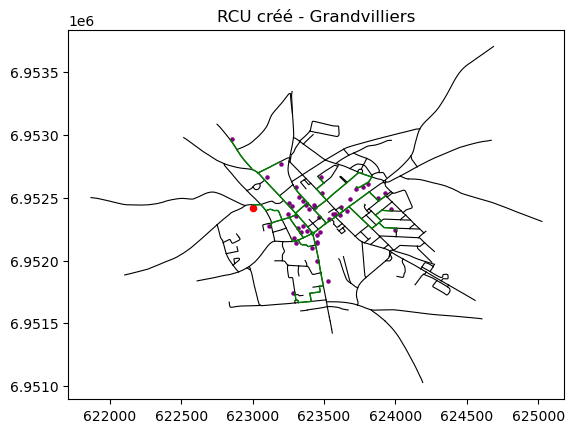

In [126]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

for route in connected_routes:
    x, y = zip(*route.coords)  # Séparation des coordonnées x et y
    plt.plot(x, y, color="green", linewidth=1, label="Routes connectées")  # Tracé en vert pour les routes connectées

# Tracé des nœuds créés (en bleu)
for building in connected_buildings:
    x, y = building["center"]  # Coordonnées extraites du champ 'center'
    plt.scatter(x, y, color="purple", s=5, label="Bâtiments connectés")

heat_plant_coords = Point(heat_plant["geometry"]["coordinates"][0][0][0])
plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=20, label="Usine à chaleur")

plt.title(f"RCU créé - {libelle_commune}")
plt.show()

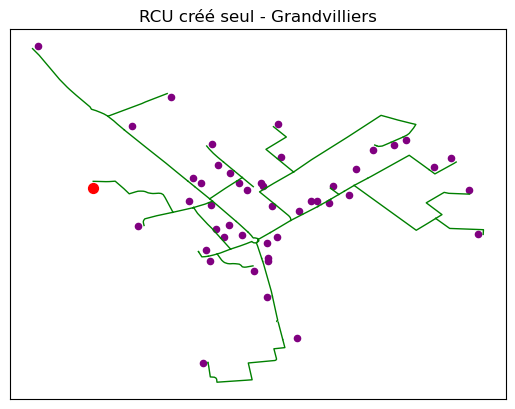

In [129]:
for route in connected_routes:
    x, y = zip(*route.coords)  # Séparation des coordonnées x et y
    plt.plot(x, y, color="green", linewidth=1, label="Routes connectées")  # Tracé en vert pour les routes connectées

# Tracé des nœuds créés (en bleu)
for building in connected_buildings:
    x, y = building["center"]  # Coordonnées extraites du champ 'center'
    plt.scatter(x, y, color="purple", s=20, label="Bâtiments connectés")

heat_plant_coords = Point(heat_plant["geometry"]["coordinates"][0][0][0])
plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=50, label="Usine à chaleur")

plt.title(f"RCU créé seul - {libelle_commune}")
plt.gca().set_xticks([]) 
plt.gca().set_yticks([])
plt.show()

**Caractéristiques du réseau :**

In [133]:
dhn_length = get_total_dhn_length(connected_routes)/1000
dhn_heat_supply = get_dhn_heat_demand(connected_buildings)/1e6
total_heat_demand = sum(heat_demands)*1e-6
heat_coverage_rate = dhn_heat_supply/total_heat_demand

print(f"Optimal Lambda : {optimal_lambda/1000:.2f} GWh/km/year")
print(f"Total heat demand : {total_heat_demand:.2f} GWh")
print(f"Heat demand covered : {dhn_heat_supply:.2f} GWh")
print(f"Number of connected buildings : {len(connected_buildings)}")
print(f"Heat coverage rate : {heat_coverage_rate*100:.2f}%") 
print(f"DHN length : {dhn_length:.2f} km")
print(f"Linear density : {dhn_heat_supply/dhn_length:.2f} GWh/km/year")

Optimal Lambda : 0.10 GWh/km/year
Total heat demand : 9.86 GWh
Heat demand covered : 6.78 GWh
Number of connected buildings : 47
Heat coverage rate : 68.77%
DHN length : 5.73 km
Linear density : 1.18 GWh/km/year


In [149]:
if linear_density > 1.5:
    print("\033[1;31mLe réseau n'est pas économiquement viable.\033[0m")
else:
    print("\033[1;32mLe réseau est économiquement viable.\033[0m")

Le réseau n'est pas économiquement viable.


### Affichage du RCU créé final, avec redécoupage

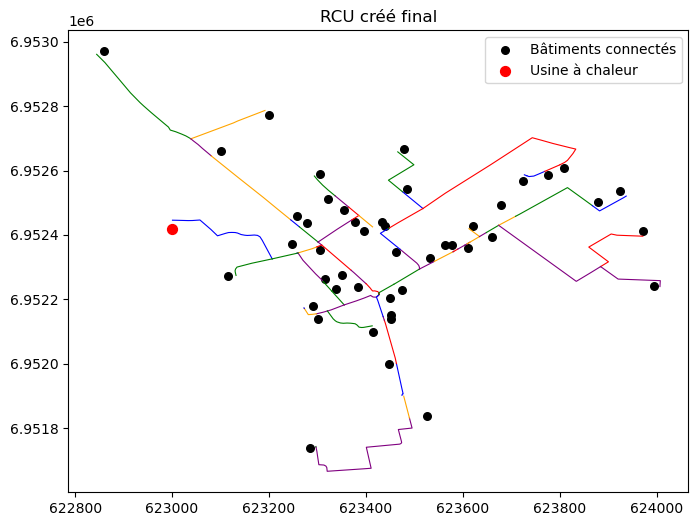

In [142]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ["blue", "green", "red", "orange", "purple"]

# Tracer les routes avec des couleurs aléatoires
for line in connected_routes:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur aléatoire pour chaque ligne
    x, y = line.xy  # Extraire les coordonnées X et Y de la ligne
    ax.plot(x, y, color=color, linewidth=0.8)

# Représentation des bâtiments par des points
for building in connected_buildings:
    x, y = building["center"]  # Coordonnées du centre du bâtiment
    ax.scatter(x, y, color="black", s=30, label="Bâtiments connectés")  # Points violets pour les bâtiments

plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=50, label="Usine à chaleur")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("RCU créé final")
plt.show()

Ce découpage permet à chaque tronçon d'être manipulé par un tuyau entre chaque bâtiment ou chaque croisement. En conséquence, il offre une manipulation plus aisée dans Dymola.

**Conversion des routes au format GeoJSON:**

In [144]:
final_dhn_roads = []

for road in connected_routes:
    geojson_geometry = mapping(road)

    
    # Étape 3 : Créer l'objet Feature sans propriétés
    feature = fiona.model.Feature(
        geometry = geojson_geometry,
        properties = { 
        "insee_commune_gauche": code_comm_insee,
        "insee_commune_droite": code_comm_insee, # Code de la commune
        "length": road.length           # Longueur de la route
    } 
    )

    final_dhn_roads.append(feature)

Reste à redéfinir de nouveau noeuds et listes de bâtiments et de routes pour l'application dans Dymola.

### Création des nouveaux noeuds pour application à Dymola

La simulation sur Dymola nécessite la création de nouveaux noeuds pour le RCU créé.

In [147]:
class Node_dhn_building:
    # Un bâtiment sera représenté par un indice et l'objet bâtiment qui y est associé
    def __init__(self, index, lambda_):
        self.index = index
        self.building = connected_buildings[index]
        x, y = self.building["center"]
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        self.heat_demand = self.building["heat_demand"]
        self.radius = self.heat_demand / lambda_
        self.construction_date = self.building["construction_date"]
        self.heat_profile_coeff = self.building["heat_profile_coeff"]

class Node_dhn_road:
    def __init__(self, index):
        self.index = index
        self.road = final_dhn_roads[index]

        # Récupérer les coordonnées brutes
        raw_coordinates = self.road["geometry"]["coordinates"]

        # Vérifier si c'est une structure 2D ou 3D, ou un type inattendu
        if isinstance(raw_coordinates[0], (list, tuple)):
            self.coordinates = [
                (coord[0], coord[1]) if len(coord) >= 2 else (coord[0], 0)
                for coord in raw_coordinates
                if isinstance(coord, (list, tuple))  # Vérifie que coord est une liste ou un tuple
            ]
        else:
            # Si la structure est une seule ligne
            self.coordinates = [
                (raw_coordinates[0], raw_coordinates[1]) if len(raw_coordinates) >= 2 else (raw_coordinates[0], 0)
            ]

        # Vérifier si des coordonnées valides ont été trouvées
        if not self.coordinates:
            raise ValueError(f"Aucune coordonnée valide trouvée pour la route à l'index {index}. "
                             f"Données initiales : {self.road['geometry']['coordinates']}")

        # Calcul du centre
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"

        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine à chaleur sera représenté par un indice et l'objet bâtiment qui y est associée
    # Différence avec les noeuds bâtiments : ni demande en chaleur ni rayon caractéristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, heat_plant=heat_plant):
        self.index = nb_dhn_buildings
        self.building = heat_plant
        self.coordinates = heat_plant["geometry"]["coordinates"][0][0]
        x, y = zip(*(self.coordinates))
        self.center = (np.mean(x), np.mean(y))
        self.type = "production de chaleur"
        self.predecessor = None

In [151]:
nb_dhn_buildings = len(connected_buildings)
nb_dhn_roads = len(final_dhn_roads)

In [153]:
# Liste des noeuds bâtiments
list_nodes_dhn_buildings = [Node_dhn_building(index, lambda_) for index in range(0, nb_dhn_buildings)] + [Node_plant(heat_plant)]
# Liste des noeuds routes
list_nodes_dhn_roads = [Node_dhn_road(index) for index in range(nb_dhn_roads)]
# Liste des arêtes entre les routes initialisée vide
list_edges_dhn_roads = {road.index : [] for road in list_nodes_dhn_roads}
# Liste des arêtes entre routes et bâtiments initialisée vide
list_edges_dhn_buildings = {building.index : [] for building in list_nodes_dhn_buildings}
# Liste des arêtes entre routes et bâtiments, mais dans l'autre sens
list_edges_dhn_roads_buildings = {road.index : [] for road in list_nodes_dhn_roads}

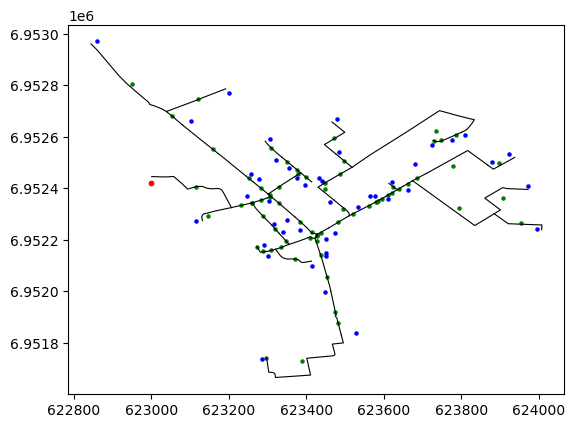

In [155]:
# Représentation graphique - batiments en rouge, routes en bleu (points), le tout relié. Si c'est assez lisible,
# on ajoutera dans un second temps le tracé des routes

# Tracé des routes et positionnement des noeuds de route
for road in list_nodes_dhn_roads:
    # Tracé des routes
    x_line1, y_line1 = zip(*road.coordinates)
    plt.plot(x_line1, y_line1, color="black", linewidth=0.8)
    # Positionnement des noeuds de route
    plt.scatter(road.center[0], road.center[1], color="green", s=5)

# Positionnement des noeuds de bâtiments
for building in list_nodes_dhn_buildings:
    x,y = building.center
    if building.type == "production de chaleur":
        plt.scatter(x, y, color="red", s=10)
    else:
        plt.scatter(x, y, color="blue", s=5)

**FIN.**